In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [9]:
housing = fetch_california_housing()
X = pd.DataFrame(housing.data, columns=housing.feature_names)
y = housing.target * 100000  # Convert to actual dollars

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_train_log, y_test_log = np.log1p(y_train), np.log1p(y_test)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [11]:
def eval_model(name, model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_original = np.expm1(y_pred)
    y_test_original = np.expm1(y_test)
    rmse = np.sqrt(mean_squared_error(y_test_original, y_pred_original))
    r2 = r2_score(y_test_original, y_pred_original)
    print(f"{name}: RMSE=${rmse:.2f}, R²={r2:.4f}")
    return {'Model': name, 'RMSE': rmse, 'R2': r2, 'Predictions': y_pred_original}

In [12]:
results = []
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=0.1),
    'SVR': SVR(kernel='rbf', C=100, gamma=0.1),
    'Decision Tree': DecisionTreeRegressor(max_depth=10),
    'Random Forest': RandomForestRegressor(n_estimators=100, max_depth=15)
}

In [13]:
# Evaluate basic models
for name, model in models.items():
    results.append(eval_model(name, model, X_train_scaled, X_test_scaled, y_train_log, y_test_log))

Linear Regression: RMSE=$153103.27, R²=-0.7888
Ridge Regression: RMSE=$152815.62, R²=-0.7821
Lasso Regression: RMSE=$92617.18, R²=0.3454
SVR: RMSE=$55488.70, R²=0.7650
Decision Tree: RMSE=$63463.70, R²=0.6926
Random Forest: RMSE=$51454.69, R²=0.7980


In [14]:
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train_scaled)
X_test_poly = poly.transform(X_test_scaled)
results.append(eval_model('Polynomial Regression', LinearRegression(), 
                         X_train_poly, X_test_poly, y_train_log, y_test_log))

Polynomial Regression: RMSE=$68202.98, R²=0.6450


In [15]:
results_df = pd.DataFrame([{k: v for k, v in r.items() if k != 'Predictions'} for r in results])
print("\nModel Performance Comparison:")
print(results_df.sort_values('R2', ascending=False))


Model Performance Comparison:
                   Model           RMSE        R2
5          Random Forest   51454.694655  0.797957
3                    SVR   55488.702683  0.765035
4          Decision Tree   63463.698652  0.692642
6  Polynomial Regression   68202.984512  0.645023
2       Lasso Regression   92617.175338  0.345400
1       Ridge Regression  152815.617816 -0.782086
0      Linear Regression  153103.270542 -0.788801



Best model: Random Forest
Best R² score: 0.7980
Best RMSE: $51454.69


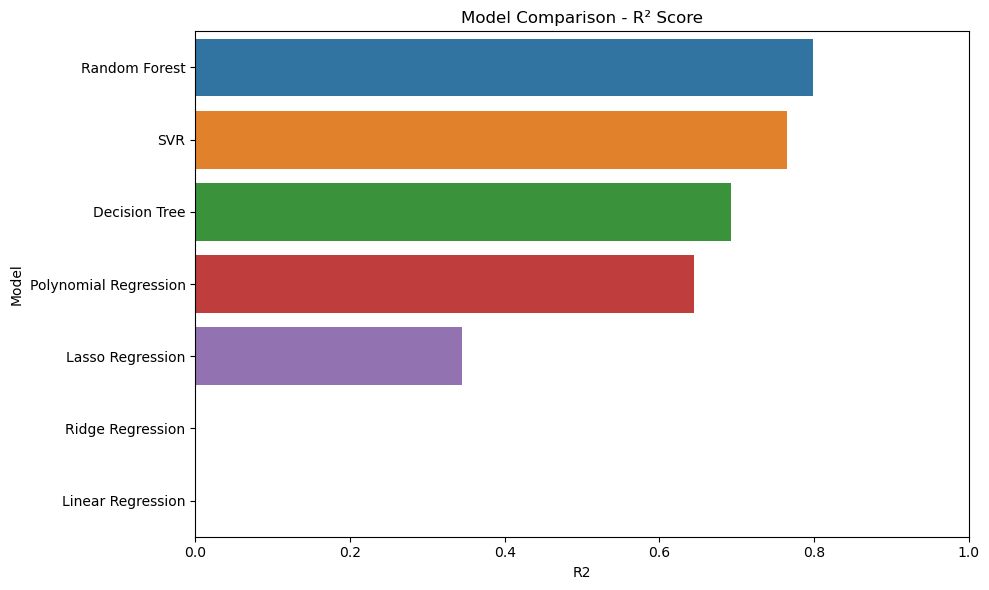

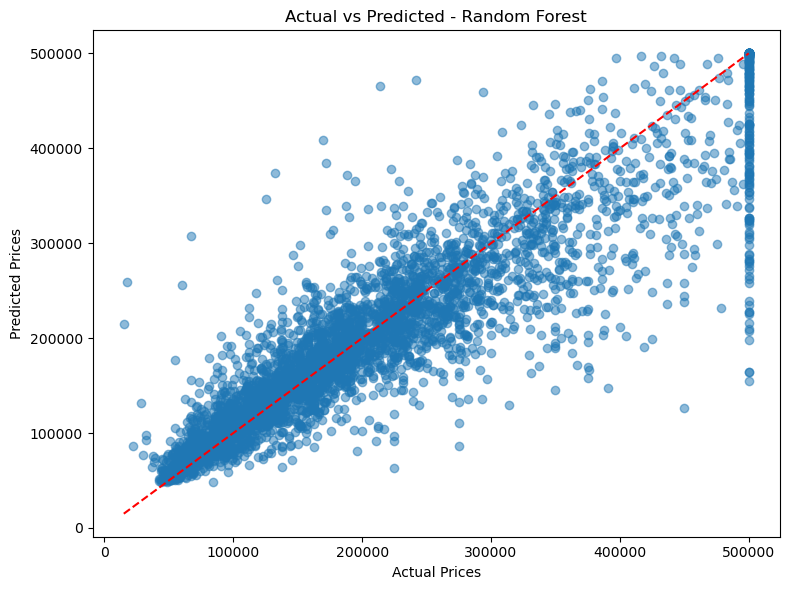

In [16]:
plt.figure(figsize=(10, 6))
sns.barplot(x='R2', y='Model', data=results_df.sort_values('R2', ascending=False))
plt.title('Model Comparison - R² Score')
plt.xlim(0, 1)
plt.tight_layout()
plt.savefig('model_comparison.png')

# Plot best model predictions
best_model = results_df.loc[results_df['R2'].idxmax(), 'Model']
best_preds = next(r['Predictions'] for r in results if r['Model'] == best_model)
y_test_original = np.expm1(y_test_log)

plt.figure(figsize=(8, 6))
plt.scatter(y_test_original, best_preds, alpha=0.5)
plt.plot([y_test_original.min(), y_test_original.max()], 
         [y_test_original.min(), y_test_original.max()], 'r--')
plt.title(f'Actual vs Predicted - {best_model}')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.tight_layout()
plt.savefig('best_model_predictions.png')

print(f"\nBest model: {best_model}")
print(f"Best R² score: {results_df.loc[results_df['R2'].idxmax(), 'R2']:.4f}")
print(f"Best RMSE: ${results_df.loc[results_df['RMSE'].idxmin(), 'RMSE']:.2f}")